In [108]:
import itertools as itt
from collections import defaultdict
import pathlib as pl
from configparser import ConfigParser

import joblib as jl
import pandas as pd
import numpy as np
from scipy.stats import sem, wilcoxon, mannwhitneyu
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Image
from webcolors import name_to_hex

from src.visualization.interactive import plot_tiling
from src.root_path import config_path, root_path
from src.visualization.palette import *
from src.utils.dataframes import add_classified_contexts

config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))

## data loading

In [2]:
mass_cluster_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220520_minimal_DF'

if 'DF' in locals(): del(locals()['DF'])
DF = jl.load(mass_cluster_DF_file)
DF.query("source == 'real' and mult_comp_corr in ['bf_cp', 'bf_ncp']  and "
         "metric in ['integral', 'last_bin']", inplace=True)

# reduces anomalously high values coming from high t values.
# these are consequences of low variances and high mean differences

DF.loc[DF['value']>10000, 'value'] = 10000
DF.loc[DF.analysis == 'PCA', 'PC'] = DF.loc[DF.analysis == 'PCA', 'id'].apply(lambda x: int(x.split('-')[-1]))


SC_DF = DF.query("analysis == 'SC' and mult_comp_corr == 'bf_cp' and metric == 'integral'")
PCA_DF = DF.query("analysis == 'PCA' and mult_comp_corr == 'bf_cp' and metric == 'integral'").copy()
PCA_DF['PC'] = PCA_DF.id.apply(lambda x: int(x.split('-')[-1]))

### example selection
this requires somewhat a better job, try finding some examples that show realy sparse neurons. No overlapping.

In [3]:
# find best site base on highes mean neuron coverage and minimum deviation in said number
# best neurons by mean integration
cell_cover = SC_DF.groupby(['region', 'site', 'id', 'stim_count']).agg(mean=('value', np.mean), std=('value', np.std))
site_cover = cell_cover.groupby(['region', 'site', 'stim_count']).agg(
    mean=('mean', np.mean), std=('mean', np.std), n_neur=('mean','count')).sort_values(
    by=['mean', 'std'], ascending=[False, False]).reset_index()
print(site_cover.head(10))

site_eg = site_cover.at[2,'site']
site_eg = 'ARM021b'
eg_site_df = cell_cover.query(f"site == '{site_eg}'").sort_values(
    by=['mean', 'std'], ascending=[False, True]).reset_index().iloc[::1,:].reset_index(drop=True)
print(eg_site_df.head())

  region     site  stim_count        mean         std  n_neur
0     A1  TNC010a          10  343.930934  211.667486       6
1     A1  TNC012a          10  221.420368   90.139308       7
2     A1  ARM005e           4  211.996984  154.726624      16
3    PEG  TNC022a          10  209.600592  234.631146      53
4    PEG  TNC024a          10  197.161973  240.595561      33
5    PEG  TNC023a          10  187.960000  239.378845      55
6    PEG  ARM022b           4  181.909907  185.625868      25
7    PEG  ARM027a           4  179.578187  133.726387      12
8    PEG  ARM021b           4  165.531676  218.659544      33
9     A1  ARM031a           4  162.900914  185.543864      46
  region     site            id  stim_count         mean          std
0    PEG  ARM021b  ARM021b-36-8           4  1102.389061  1488.193622
1    PEG  ARM021b  ARM021b-43-8           4   520.902313   408.855825
2    PEG  ARM021b  ARM021b-40-6           4   497.253383   452.941899
3    PEG  ARM021b  ARM021b-05-1       

In [18]:
SC_DF

,id,context_pair,probe,value,metric,mult_comp_corr,analysis,site,region,source,cluster_threshold,stim_count,PC
0,ARM019a-03-6,00_01,1,0.0,integral,bf_cp,SC,ARM019a,PEG,real,0.05,4,NaN
1,ARM019a-06-5,00_01,1,0.0,integral,bf_cp,SC,ARM019a,PEG,real,0.05,4,NaN
2,ARM019a-07-6,00_01,1,0.0,integral,bf_cp,SC,ARM019a,PEG,real,0.05,4,NaN
3,ARM019a-10-5,00_01,1,0.0,integral,bf_cp,SC,ARM019a,PEG,real,0.05,4,NaN
4,ARM019a-10-6,00_01,1,0.0,integral,bf_cp,SC,ARM019a,PEG,real,0.05,4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3866820,TNC047a-37-1,09_10,10,0.0,integral,bf_cp,SC,TNC047a,PEG,real,0.05,10,NaN
3866821,TNC047a-37-2,09_10,10,0.0,integral,bf_cp,SC,TNC047a,PEG,real,0.05,10,NaN
3866822,TNC047a-40-1,09_10,10,0.0,integral,bf_cp,SC,TNC047a,PEG,real,0.05,10,NaN
3866823,TNC047a-43-1,09_10,10,0.0,integral,bf_cp,SC,TNC047a,PEG,real,0.05,10,NaN


/auto/users/mateo/miniconda3/envs/cpa_tf/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

/auto/users/mateo/miniconda3/envs/cpa_tf/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)



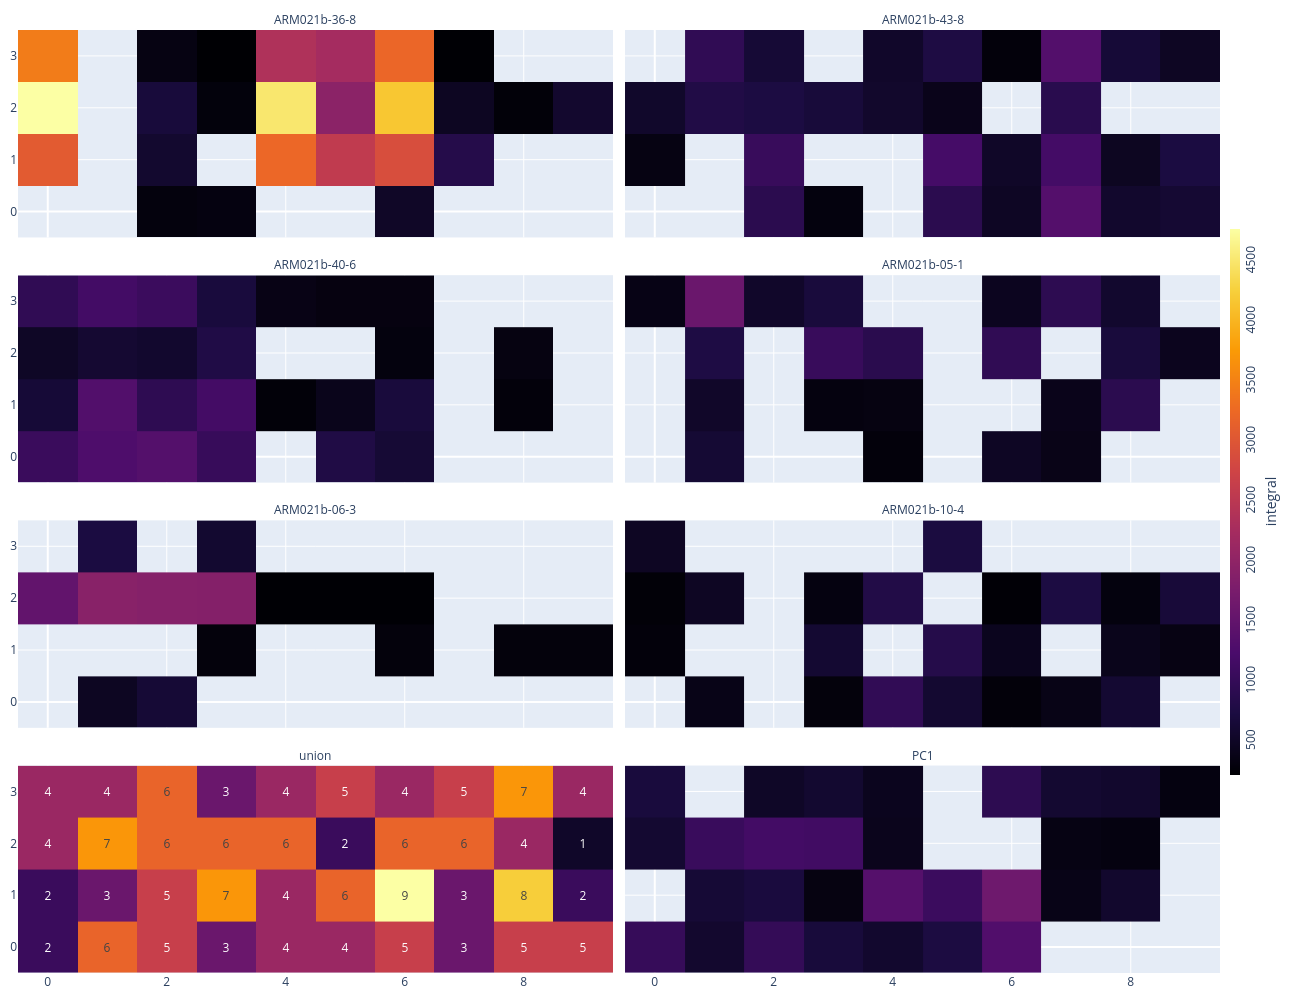

In [4]:
def plot_fingerprint(cellid):
    df = SC_DF.query(f"id == '{cellid}'")
    z = df.pivot(index='probe', columns='context_pair', values='value').values
    # z = z / np.max(z)
    z[z==0] = np.nan
    heatmap = go.Figure(go.Heatmap(z=z,coloraxis='coloraxis',connectgaps=False))
    try:
        thismax= np.nanmax(z)
    except:
        thismax = 0

    return heatmap, thismax

n_egs = 6 # this  number must be even
cell_egs = eg_site_df.loc[:n_egs-1,'id'].tolist()
titles = cell_egs+['union', 'PC1']
max_vals = list()
fig = make_subplots(int(n_egs/2+1) , 2,
                    shared_xaxes=True, shared_yaxes=True,
                    horizontal_spacing=0.01,vertical_spacing=0.04,
                    subplot_titles=titles)

# individual neuron examples
for cc, cell_eg in enumerate(cell_egs):
    hmap, maxval = plot_fingerprint(cell_eg)
    max_vals.append(maxval)
    row, col = int(np.floor(cc/2))+1, (cc%2)+1
    hmap = hmap['data']
    fig.add_traces(hmap, rows=[row]*len(hmap), cols=[col]*len(hmap))

# first principal component
PCA_arr = PCA_DF.query(f"site == '{site_eg}' and PC == 1"
                       ).pivot(index='probe', columns='context_pair', values='value').values
max_vals.append(PCA_arr.max())
PCA_arr[PCA_arr==0] = np.nan
pc1 =go.Heatmap(z=PCA_arr,coloraxis='coloraxis',connectgaps=False)
# pc = px.imshow(PCA_arr, origin='lower',)['data']
fig.add_trace(pc1, row=int(n_egs/2+1), col=2)

# union
union_arr = DF.query(
    f"analysis == 'SC' and mult_comp_corr == 'bf_ncp' and site == '{site_eg}' and "
    f"metric == 'integral'"
).pivot_table(
    index='probe', columns='context_pair', values='value', aggfunc=lambda x: np.sum(x>0)).values
toplot = union_arr / union_arr.max() * np.max(max_vals) # normalizatio of counts based on metric values
union = go.Figure(data=go.Heatmap(z=toplot, coloraxis='coloraxis',connectgaps=False))
union.update_traces(text=union_arr, texttemplate='%{text}') # add the count number to each cell, this wont be displayed by jupyternotebooks...
union = union['data']
fig.add_traces(union, rows=[int(n_egs/2+1)]*len(union), cols=[1]*len(union))


# some minor formating
fig.update_annotations(font_size=12)
fig.update_layout(margin=dict(l=10, r=10, t=30, b=10),
                  coloraxis=dict(colorscale='inferno',
                                     colorbar=dict(
                                         thickness=10, len=0.6,
                                         title_text='integral',
                                         title_side='right',
                                         tickangle=-90,
                                         xanchor='left', x=1)
                                     )
                  )
# fig.show()
img_bytes = fig.to_image(format="png", width=1300, height=1000)
Image(img_bytes)

# example neuron tilings
plus first pc and count of significant instances
corrected for multiple comparison of neurons

In [5]:
panels = defaultdict(list)

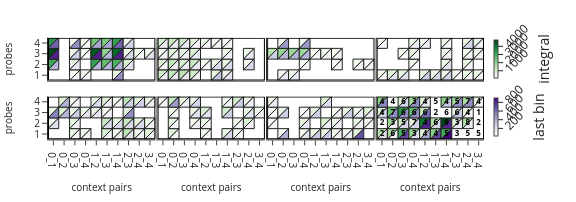

In [6]:
base_panelname = 'tile_eg'
orientation = 'h'  # do not change

n_egs = 7  # this  number must be odd
cell_egs = eg_site_df.loc[:n_egs - 1, 'id'].tolist()
pc_eg = f'{site_eg}-PC-1'
# get max values for normalization
toplot = DF.query(f"id in {cell_egs + [pc_eg, ]}")
zmax = toplot.groupby('metric').agg(value=('value', np.max)).to_dict()['value']

# individual neuron examples
for cc, cell_eg in enumerate(cell_egs):
    # hmap = plot_tiling(cell_eg, toplot,zmax=zmax, show_coloraxis=False)
    hmap = plot_tiling(cell_eg, toplot, zmax=zmax, show_coloraxis=False, orientation=orientation,
                       cscales={'integral': 'Greens',
                                'last_bin': 'Purples'})


    panelname = f'{base_panelname}_{cc}'
    if panelname in panels:
        panels.pop(panelname)
    panels[panelname].extend(hmap['data'])

# Principal components example with count number
hmap = plot_tiling(pc_eg, toplot, show_coloraxis=False, orientation=orientation,
                   cscales={'integral': 'Greens',
                            'last_bin': 'Purples'})

# count singificant instances across all singleneurons
union_DF = DF.query(
    f"analysis == 'SC' and mult_comp_corr == 'bf_ncp' and site == '{site_eg}' and "
    f"metric == 'integral'"
).pivot_table(
    index='probe', columns='context_pair', values='value', aggfunc=lambda x: np.sum(x > 0))
union_arr = union_DF.values

# organize xy positions and counts in vector
txt_arr = np.empty([union_arr.size, 3]).astype(object)
for nn, (p, c) in enumerate(np.ndindex(union_arr.shape)):
    if orientation == 'v':
        txt_arr[nn, :2] = [p, c]
    elif orientation == 'h':
        txt_arr[nn, :2] = [c, p]
    txt_arr[nn, 2] = f'<b>{union_arr[p, c]}<b>' # bold
    # txt_arr[nn, 2] = str(union_arr[p, c])

# adds text on top of heatmap
hmap.add_trace(go.Scatter(x=txt_arr[:, 0] + 0.5, y=txt_arr[:, 1] + 0.5, text=txt_arr[:, 2],
                          mode="text",
                          textfont=dict(size=8,
                                        color='Black'),
                          showlegend=False))

panelname = f'{base_panelname}_PC'
if panelname in panels:
    panels.pop(panelname)
panels[f'{base_panelname}_PC'].extend(hmap['data'])


# save some extra varialbles for easye layout formating
context_pairs = [f"{int(pp.split('_')[0])}_{int(pp.split('_')[1])}"
                 for pp in union_DF.columns.to_list()]
probes = union_DF.index.tolist()

if orientation == 'v':
    yrange = [0, len(context_pairs)]
    ytitle = 'context pairs'
    ytickvals = np.arange(len(context_pairs)) + 0.5
    yticktext = context_pairs

    xrange = [0, len(probes)]
    xtitle = 'probes'
    xtickvals = np.arange(len(probes)) + 0.5
    xticktext = probes

elif orientation == 'h':
    xrange = [0, len(context_pairs)]
    xtitle = 'context pairs'
    xtickvals = np.arange(len(context_pairs)) + 0.5
    xticktext = context_pairs

    yrange = [0, len(probes)]
    ytitle = 'probes'
    ytickvals = np.arange(len(probes)) + 0.5
    yticktext = probes



##### test  plot
fig = make_subplots(
    # int((n_egs-1)/2+1) , 2, # horizontal
    2, int((n_egs - 1) / 2 + 1),
    shared_xaxes=True, shared_yaxes=True,
    horizontal_spacing=0.005, vertical_spacing=0.005)

for cc, cell_eg in enumerate(cell_egs):
    panelname = f'{base_panelname}_{cc}'

    # row, col = int(np.floor(cc/2))+1, (cc%2)+1 # horizontal
    col, row = int(np.floor(cc / 2)) + 1, (cc % 2) + 1
    pan = panels[panelname]
    fig.add_traces(pan, rows=[row] * len(pan), cols=[col] * len(pan))

pan = panels[f'{base_panelname}_PC']
fig.add_traces(pan, rows=[2] * len(pan), cols=[int((n_egs - 1) / 2 + 1)] * len(pan))

fig.update_layout(template="simple_white",
                  margin=dict(l=30, r=30, t=30, b=30),
                  coloraxis=dict(colorscale='Greens',
                                 colorbar=dict(
                                     thicknessmode='fraction',
                                     thickness=0.01, len=0.5,
                                     title_text='integral',
                                     title_side='right',
                                     tickangle=-45,
                                     xanchor='left', x=1,
                                     yanchor='bottom', y=0.5)
                                 ),
                  coloraxis2=dict(colorscale='Purples',
                                  colorbar=dict(
                                      thicknessmode='fraction',
                                      thickness=0.01, len=0.5,
                                      title_text='last bin',
                                      title_side='right',
                                      tickangle=-45,
                                      xanchor='left', x=1,
                                      yanchor='bottom', y=0)
                                  ),
                  # coloraxis=dict(showscale=False),
                  # coloraxis2=dict(showscale=False),
                  )

for nn, (row, col) in enumerate(itt.product(range(1, 3), range(1, 5))):

    scale_anchor = 'y' if nn == 0 else f'y{nn}'
    fig.update_xaxes(scaleanchor=scale_anchor,
                     constrain='domain',
                     range=xrange, fixedrange=True,
                     row=row, col=col)
    fig.update_yaxes(constrain='domain',
                     range=yrange, fixedrange=True,
                     row=row, col=col)

    if row == 1:
        fig.update_xaxes(showticklabels=False, ticks='',
                         row=row, col=col)
    else:
        fig.update_xaxes(title_text=xtitle,
                         title_font_size=10,
                         tickmode='array',
                         tickvals=xtickvals,
                         ticktext=xticktext,
                         tickfont_size=10,
                         row=row, col=col)

    if col == 1:
        fig.update_yaxes(title_text=ytitle,
                         title_font_size=10,
                         tickmode='array',
                         tickvals=ytickvals,
                         ticktext=yticktext,
                         tickfont_size=10,
                         row=row, col=col)
    else:
        fig.update_yaxes(showticklabels=False, ticks='',
                         row=row, col=col)


ppi = 96 # standard monitor?

img_bytes = fig.to_image(format="png",
                         width=round(ppi * 6),
                         height=round(ppi * 2.1))
Image(img_bytes)

# Summary of coverages
considering ither single cells, best, union or first  PC

In [78]:
# Creates summary DF for these different quantifications of coverage

def union_cover(df):
    df = df.pivot_table(index='id', columns=['context_pair', 'probe'], values='value', aggfunc='first')
    arr =  df.dropna(axis=1).values > 0
    union = np.any(arr, axis=0)
    return union.sum()/union.size * 100

def best_neuron(df):
    df = df.pivot_table(index='id', columns=['context_pair', 'probe'], values='value', aggfunc='first')
    arr =  df.dropna(axis=1).values > 0
    neu_cvr = arr.sum(axis=1) / arr.shape[1] * 100
    return neu_cvr.max()

# all single neuron coverages
by_neuron = DF.query(
    "analysis == 'SC' and mult_comp_corr == 'bf_cp' and metric == 'integral'"
).groupby(['region', 'site', 'id']).agg(value=('value', lambda x: np.sum(x>0)/x.size *100))

# best neuron in site
by_best =  DF.query(
    "analysis == 'SC' and mult_comp_corr == 'bf_cp' and metric == 'integral'"
).groupby(['region', 'site']).apply(best_neuron)
by_best.name = 'value'

# Union of single neurons, note the more strict bonferroni
by_union =  DF.query(
    "analysis == 'SC' and mult_comp_corr == 'bf_ncp' and metric == 'integral'"
).groupby(['region', 'site']).apply(union_cover)
by_union.name = 'value'

# First PC coverage
by_PC1 = DF.query(
    "analysis == 'PCA' and PC == 1 and mult_comp_corr == 'bf_cp' and metric == 'integral'"
).groupby(['region', 'site']).agg(value=('value', lambda x: np.sum(x>0)/x.size *100))


to_concat = {'SC':by_neuron, 'best_SC':by_best ,'union': by_union, 'PC1':by_PC1,}
toplot = list()
for name, df in to_concat.items():
    df = df.reset_index()
    df['quant'] = name
    toplot.append(df)
toplot = pd.concat(toplot)


# concatenate
to_concat = {'SC':by_neuron, 'best_SC':by_best ,'union': by_union, 'PC1':by_PC1}
toplot = list()
for name, df in to_concat.items():
    df = df.reset_index()
    df['quant'] = name
    toplot.append(df)
toplot = pd.concat(toplot)

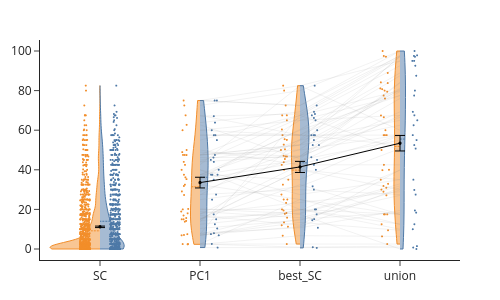

In [79]:
panelname = "coverage_summary"

fig = go.Figure()

# violins plust pointplots
for qq, quant in enumerate(['SC', 'PC1', 'best_SC', 'union']):
    fig.add_trace(go.Violin(x=toplot['quant'][(toplot['region'] == 'A1') &
                                              (toplot['quant'] == quant)],
                            y=toplot['value'][(toplot['region'] == 'A1') &
                                              (toplot['quant'] == quant)],
                            legendgroup='A1', scalegroup=f'', name='A1',
                            side='negative',
                            pointpos=-0.3,  # where to position points
                            line=dict(color=A1_COLOR,
                                      width=1),
                            showlegend=False,
                            meanline=dict(width=1,
                                          ))
                  )
    fig.add_trace(go.Violin(x=toplot['quant'][(toplot['region'] == 'PEG') &
                                              (toplot['quant'] == quant)],
                            y=toplot['value'][(toplot['region'] == 'PEG') &
                                              (toplot['quant'] == quant)],
                            legendgroup='PEG', scalegroup=f'', name='PEG',
                            side='positive',
                            pointpos=0.3,
                            line=dict(color=PEG_COLOR,
                                      width=1),
                            showlegend=False,
                            meanline=dict(width=1,
                                          ))
                  )

# update characteristics shared by all traces
fig.update_traces(meanline_visible=True,
                  marker_size=2,
                  points='all',
                  jitter=0.1,
                  scalemode='width',
                  spanmode='hard')

# add lines connecting dots for groups
linearr = toplot.query("quant in ['best_SC', 'PC1', 'union']").pivot(index='site', columns='quant', values='value'
                                                                     ).loc[:, ['PC1', 'best_SC', 'union']].values

# individual grayed out lines
x = ['PC1', 'best_SC', 'union']
for ll, line in enumerate(linearr):
    fig.add_trace(go.Scatter(x=x, y=line,
                             mode='lines',
                             opacity=0.1,
                             line=dict(
                                 color='gray',
                                 width=1)
                             ,
                             showlegend=False)
                  )

# mean values pluse error bars
mean = linearr.mean(axis=0)
err = sem(linearr, axis=0)
fig.add_trace(go.Scatter(x=x, y=mean,
                         mode='markers+lines',
                         opacity=1,
                         showlegend=False,
                         marker=dict(color='black',
                                     symbol='square',
                                     size=2,
                                     line=dict(color='black',
                                               width=1)
                                     ),
                         error_y=dict(array=err,
                                      color='black',
                                      thickness=1,
                                      width=5
                                      ),
                         line=dict(color='black',
                                   width=1
                                   )
                         ))

# mean for the single cell pooled values
SC_arr = toplot.query("quant == 'SC'").value.values
mean = SC_arr.mean()
err = sem(SC_arr)

fig.add_trace(go.Scatter(x=['SC'], y=[mean],
                         mode='markers',
                         opacity=1,
                         showlegend=False,
                         marker=dict(color='black',
                                     symbol='square',
                                     size=2,
                                     line=dict(color='black',
                                               width=1)
                                     ),
                         error_y=dict(array=[err],
                                      color='black',
                                      thickness=1,
                                      width=5
                                      ),
                         ))

if panelname in panels:
    panels.pop(panelname)
panels[panelname] = fig['data']

# test show
# fig.show()
fig.update_layout(
    template='simple_white',
    margin=dict(l=40, r=40, t=40, b=40),
    xaxis=dict(range=[-0.6, 3.6]),
    violingap=0, violingroupgap=0, violinmode='overlay'
)
img_bytes = fig.to_image(format="png", width=500, height=300)
Image(img_bytes)

## stat quantification
Only relevant to quantify between adyacent columns??

In [80]:
# compare between quantifications
stats_df = list()
for q0, q1 in itt.combinations(toplot.quant.unique(), 2):
    if 'SC' in [q0, q1]:
        x = toplot.query(f"quant == '{q0}'").value.values
        y = toplot.query(f"quant == '{q1}'").value.values
        assert np.all(~np.isnan(x))
        assert np.all(~np.isnan(y))
        out = mannwhitneyu(x,y)
        stat = 'mannwhitneyu'
    else:
        ddd = toplot.query(f"quant in {[q0, q1]}").pivot(index='site', columns='quant', values='value')
        x = ddd[q0].values
        y = ddd[q1].values
        assert np.all(~np.isnan(x))
        assert np.all(~np.isnan(y))
        out = wilcoxon(x,y)
        stat = 'wilcoxon'

    d = {'pair':f'{q0}_vs_{q1}', 'stat': stat, 'pvalue': out.pvalue}
    stats_df.append(d)

stats_df = pd.DataFrame(stats_df)
alpha = 0.01 / stats_df.shape[0]
stats_df['signif'] = stats_df['pvalue'] < alpha
stats_df

,pair,stat,pvalue,signif
0,SC_vs_best_SC,mannwhitneyu,3.863550e-25,True
1,SC_vs_union,mannwhitneyu,1.553574e-26,True
2,SC_vs_PC1,mannwhitneyu,3.175605e-19,True
3,best_SC_vs_union,wilcoxon,1.094478e-06,True
4,best_SC_vs_PC1,wilcoxon,1.445772e-05,True
5,union_vs_PC1,wilcoxon,4.203865e-09,True


In [81]:
# compare regions per quantification
stats_df = list()
for quant in toplot.quant.unique():
    if quant == 'SC':
        idx = 'id'
    else:
        idx = 'site'

    x = toplot.query(f"quant == '{quant}' and region == 'A1'").value.values
    y = toplot.query(f"quant == '{quant}' and region == 'PEG'").value.values

    assert np.all(~np.isnan(x))
    assert np.all(~np.isnan(y))
    out = mannwhitneyu(x,y)
    stat = 'mannwhitneyu'

    d = {'quant':quant, 'stat': stat, 'pvalue': out.pvalue}
    stats_df.append(d)

stats_df = pd.DataFrame(stats_df)
alpha = 0.01 / stats_df.shape[0]
stats_df['signif'] = stats_df['pvalue'] < alpha
stats_df

,quant,stat,pvalue,signif
0,SC,mannwhitneyu,7.754141e-08,True
1,best_SC,mannwhitneyu,2.386321e-01,False
2,union,mannwhitneyu,3.202441e-01,False
3,PC1,mannwhitneyu,2.181598e-01,False


# single cell coverage
including null dristribution

In [11]:
summary_real_vs_shuff_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220602_SC_real_shuffled'
SC_count = jl.load(summary_real_vs_shuff_DF_file)

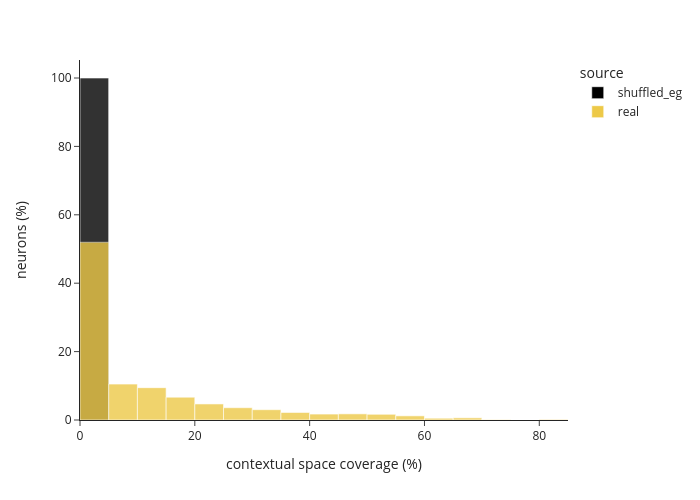

In [12]:
panelname = 'SC_coverage_not_random'

toplot = SC_count.query("metric ==  'integral' and  mult_comp_corr == 'bf_cp'").groupby(['source','id']).agg(
    space_cover_pct=("value", lambda x: sum(x>0)/len(x)*100)).reset_index()

fig = px.histogram(data_frame=toplot, x="space_cover_pct", nbins=20,
                   color='source',
                   category_orders={'source':['shuffled_eg','real']},
                   color_discrete_map={'real':Yellow, 'shuffled_eg':'black'},
                   histnorm='percent',
                   opacity=0.8,
                   barmode='overlay',
                   log_x=False)
fig.update_xaxes(title=dict(text='contextual space coverage (%)'))
fig.update_yaxes(title=dict(text='neurons (%)'))
fig.update_layout(template='simple_white', showlegend=True)

if panelname in panels:
    panels.pop(panelname)
panels[panelname] = fig['data']
# fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

# surface plots with marginals
 to showcase

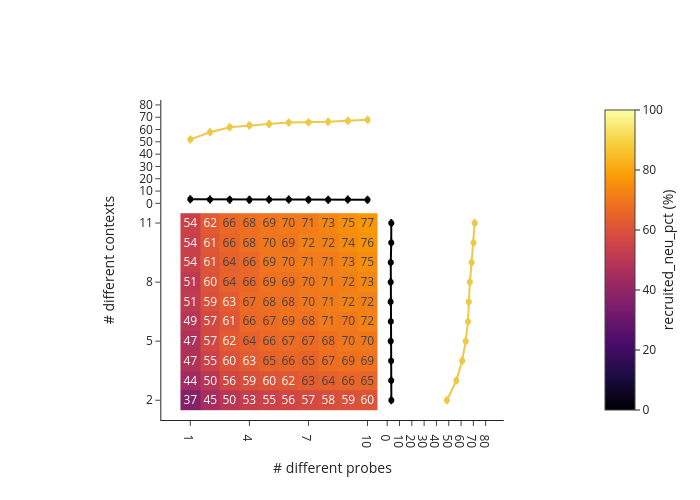

In [13]:
panelname = 'space_subsampling'
subsampling_path = pl.Path(config['paths']['analysis_cache']) / '220310_pval_subsamp_DF_update'
subDF = jl.load(subsampling_path)

# defines the rage of the color map and the marginal plots. and what proportion of the plots the marginals should occupy
zmax = 80
marg_prop = 0.5
nticks_sound  = 4

# based  on the prior defines the extent that the heatmap has to ocuppy
heatmap0 =  -zmax/marg_prop
heatmapd = -heatmap0/10

# defines the heatmap tick positions
sound_tickpos = np.linspace(int(heatmap0),int(heatmap0+heatmapd*9), nticks_sound,endpoint=True)
sound_xlabs = np.linspace(1,10, nticks_sound).astype(int)
sound_ylabs = np.linspace(2,11, nticks_sound).astype(int)

# adds ticks and labels for the marginals
marg_tickpos = np.linspace(0,zmax, int(zmax/10)+1, endpoint=True, dtype=int) # position == label

ticks = np.concatenate([sound_tickpos, marg_tickpos])
xticklabs = np.concatenate([sound_xlabs, marg_tickpos])
yticklabs = np.concatenate([sound_ylabs, marg_tickpos])



##### heat map of mean real values for all combinationse of context and probes #####
real = subDF.groupby(['source', 'n_ctx', 'n_prb']).agg(mean=('recruited_neu_pct', np.mean)
                                                       ).loc['real'].reset_index().pivot(index='n_prb', columns='n_ctx',
                                                                                         values='mean')

# heatmap

# hm = go.Heatmap(x=real.index.values, y=real.columns.values, z=real.values,
#                 coloraxis='coloraxis')

fig = go.Figure()

fig.add_trace(go.Heatmap(x0=heatmap0, dx=heatmapd, y0=heatmap0, dy=heatmapd, z=real.values,
                coloraxis='coloraxis3'))
fig.update_traces(text=real.values, texttemplate='%{text:.0f}')


# Probe marginal,
prb_marg = subDF.groupby(['source', 'n_prb']).agg(mean=('recruited_neu_pct', np.mean),
                                                  sem=('recruited_neu_pct', sem),
                                                  std=('recruited_neu_pct', np.std),
                                                  )

for source, color in zip(['real', 'shuffled_eg'],[Yellow, 'black']):
    y = prb_marg.loc[source, 'mean'].values
    err = prb_marg.loc[source, 'sem'].values
    fig.add_trace(go.Scatter(x0=heatmap0, dx=heatmapd, y=y, mode='markers+lines',
                             line=dict(color=color,
                                       width=2),
                             marker=dict(),
                             error_x=dict(array=err),
                             showlegend=False
                             ))

# contex marginal
ctx_marg = subDF.groupby(['source', 'n_ctx']).agg(mean=('recruited_neu_pct', np.mean),
                                                  sem=('recruited_neu_pct', sem),
                                                  std=('recruited_neu_pct', np.std),
                                                  )

for source, color in zip(['real', 'shuffled_eg'],[Yellow, 'black']):
    x = ctx_marg.loc[source, 'mean'].values
    err = ctx_marg.loc[source, 'sem'].values
    fig.add_trace(go.Scatter(x=x, y0=heatmap0, dy=heatmapd, mode='markers+lines',
                             line=dict(color=color,
                                       width=2),
                             marker=dict(),
                             error_x=dict(array=err),
                             showlegend=False
                             ))

if panelname in panels:
    panels.pop(panelname)
panels[panelname] = fig['data']

##### general
fig.update_layout(template='simple_white',autosize=False,
                  xaxis=dict(title_text='# different probes',
                     anchor='y', constrain='domain', scaleanchor='y',
                             tickmode = 'array',
                             tickvals = ticks,
                             ticktext = xticklabs),
                  yaxis=dict(title_text='# different contexts',
                     anchor='x', autorange=True, constrain='domain',
                             tickmode = 'array',
                             tickvals = ticks,
                             ticktext = yticklabs),
                  coloraxis3=dict(cmin=0, cmax=100,
                                 colorscale='inferno',
                                 colorbar=dict(
                                     title=dict(
                                         text=f'recruited_neu_pct (%)',
                                         side='right'
                                     ))))
# fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

## without marginals

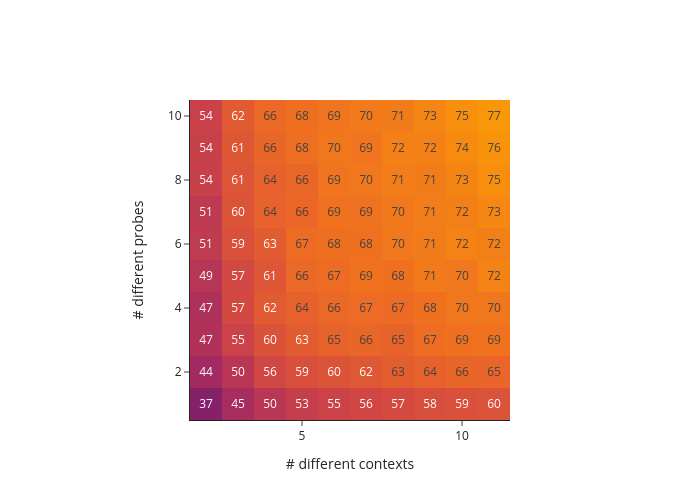

In [20]:
panelname = 'space_subsampling_nomarg'
subsampling_path = pl.Path(config['paths']['analysis_cache']) / '220310_pval_subsamp_DF_update'
subDF = jl.load(subsampling_path)

# defines the rage of the color map and the marginal plots. and what proportion of the plots the marginals should occupy
##### heat map of mean real values for all combinationse of context and probes #####
real = subDF.groupby(['source', 'n_ctx', 'n_prb']).agg(mean=('recruited_neu_pct', np.mean)
                                                       ).loc['real'].reset_index().pivot(index='n_prb', columns='n_ctx',
                                                                                         values='mean')

# heatmap
fig = go.Figure().add_trace(
    go.Heatmap(x=real.columns.values, y=real.index.values, z=real.values,
                coloraxis='coloraxis3')
)

fig.update_traces(text=real.values, texttemplate='%{text:.0f}')

if panelname in panels:
    panels.pop(panelname)
panels[panelname] = fig['data']

##### general
fig.update_layout(template='simple_white',autosize=False,
                  xaxis=dict(title_text='# different contexts',
                     anchor='y', constrain='domain', scaleanchor='y',
                             ),
                  yaxis=dict(title_text='# different probes',
                     anchor='x', autorange=True, constrain='domain',
                             ),
                  coloraxis3=dict(cmin=0, cmax=100,
                                 showscale=False,
                                 colorscale='inferno',
                                 colorbar=dict(
                                     title=dict(
                                         text=f'recruited_neu_pct (%)',
                                         side='right'
                                     ))))
# fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

In [15]:
real

n_ctx,2,3,4,5,6,7,8,9,10,11
n_prb,,,,,,,,,,
1,36.603425,44.850535,49.762053,52.925643,54.655067,56.114498,57.335103,58.442780,59.405938,60.131320
2,43.857028,49.742245,56.436028,59.068343,60.220418,61.633918,63.209745,64.249646,65.630479,65.474943
3,47.289237,54.606365,59.675924,62.679600,64.753720,65.574219,64.831096,67.456479,68.523232,68.714625
4,46.822029,56.985083,62.141559,64.364387,66.421580,67.026927,66.921761,68.489896,69.688131,69.717725
5,49.199546,56.679468,61.051860,66.246881,67.219704,68.661385,68.409131,70.506306,70.010271,72.228861
6,51.262612,59.437492,62.782911,67.067879,68.093720,68.447774,70.004717,70.591927,72.241961,71.772920
7,50.874885,60.436029,64.433942,65.902135,68.679434,68.635946,70.101926,71.153939,71.535748,73.441764
8,53.727071,60.722582,64.307068,66.085592,69.226308,70.060996,71.119939,70.870067,72.973486,74.826069
9,53.657638,61.204555,65.626928,67.851655,69.841349,69.348603,71.988586,72.077927,74.192168,75.983230


# Region differences
same as summary for figure 2, but using first PC instead of individual neurons

In [67]:
# for metric in ["integral", "last_bin"],:
def plot_metric_quant_bars(metric, category, innerDF):
    print(f'{metric}, {category}')
    tocalc = innerDF.query(f"metric == '{metric}' and value > 0")
    # tocalc = tocalc.groupby(['trans_pair', 'region', 'id']).agg(value=('value', 'mean')).reset_index()
    tocalc = tocalc.replace({'silence_diff': 'sile_diff', 'silence_same': 'sile_same'})

    if category == 'transition':
        ### transitions ###
        toplot = tocalc.groupby('trans_pair').agg(stat=('value', np.mean),
                                                  err=('value', sem))

        for c0,c1 in itt.combinations(tocalc.trans_pair.unique().tolist(), 2):
            x = tocalc.loc[tocalc.trans_pair == c0, 'value'].values.astype(float)
            y = tocalc.loc[tocalc.trans_pair == c1, 'value'].values.astype(float)
            stat, pval = mannwhitneyu(x,y)
            print(f'{c0} vs {c1} MannwhitneyU {pval}')

        return [
            go.Scatter(x=toplot.index, y=toplot['stat'], mode='markers',
                       marker=dict(color='black'),
                       error_y=dict(array=toplot['err'],
                                    color=name_to_hex('black')),
                       showlegend=False)
        ]

    ### regions ###
    elif category == 'region':
        x = tocalc.loc[tocalc.region == 'A1', 'value'].values.astype(float)
        y = tocalc.loc[tocalc.region == 'PEG', 'value'].values.astype(float)
        stat, pval = mannwhitneyu(x,y)

        toplot = tocalc.groupby('region').agg(stat=('value', np.mean),
                                              err=('value', sem))
        print(f'A1 vs PEG MannwhitneyU {pval}')

        # if you want different color error bars, have to do it one at a time
        reg_quant = list()
        for ii, color in enumerate([Blue, Orange]):
            reg_quant.append(go.Scatter(x=(toplot.index[ii],), y=(toplot['stat'][ii],), mode='markers',
                                        marker_color=color,
                                        error_y=dict(array=toplot['err'],
                                                     color=color),
                                        showlegend=False),
                             )

        return reg_quant
    else:
        raise ValueError(f'bad param {category}')




PCA_filtered = DF.query(
    "analysis == 'PCA' and PC == 1 and mult_comp_corr == 'bf_cp' "
    "and metric in ['integral', 'last_bin'] "
    "and value > 0 and value < 10000")
PCA_filtered = add_classified_contexts(PCA_filtered)


fig = make_subplots(2,2)
for mm, met in enumerate(['integral', 'last_bin']):
    for cc, cat in enumerate(['transition', 'region']):

        panelname = f'{met}_{cat}'

        if panelname in panels:
            panels.pop(panelname)

        panels[panelname].extend(plot_metric_quant_bars(met, cat, PCA_filtered))


        pan = panels[panelname]
        fig.add_traces(pan, cols=[cc+1]*len(pan), rows=[mm+1]*len(pan))
fig.show()


integral, transition
diff_silence vs diff_diff MannwhitneyU 2.2272571656645547e-06
diff_silence vs diff_same MannwhitneyU 1.1018338254332506e-09
diff_silence vs same_silence MannwhitneyU 0.0034354709134796235
diff_diff vs diff_same MannwhitneyU 0.002411428003368543
diff_diff vs same_silence MannwhitneyU 0.25712308630521113
diff_same vs same_silence MannwhitneyU 0.2242053194731553
integral, region
A1 vs PEG MannwhitneyU 4.793036866886423e-10
last_bin, transition
diff_silence vs diff_diff MannwhitneyU 0.00015823321063355034
diff_silence vs diff_same MannwhitneyU 0.000371306045978586
diff_silence vs same_silence MannwhitneyU 0.1936207573319691
diff_diff vs diff_same MannwhitneyU 0.24193761705177608
diff_diff vs same_silence MannwhitneyU 0.20936946795448602
diff_same vs same_silence MannwhitneyU 0.13087211304733004
last_bin, region
A1 vs PEG MannwhitneyU 0.0063326356211330734


/auto/users/mateo/code/context_probe_analysis/src/utils/dataframes.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# figure layout

In [114]:
# simple plot layout and other figurewide configurations
def define_subplots():
    fig = make_subplots(rows=5, cols=4, vertical_spacing=0.01, horizontal_spacing=0.01,
                        column_widths=[1 / 4, 1 / 4, 1 / 4, 1 / 4],
                        row_heights=[1 / 8, 1 / 8, 3 / 8, 3 / 16, 3 / 16],
                        specs=[[{}, {}, {}, {}],
                               [{}, {}, {}, {}],
                               [{'colspan': 2, 't': 0.1, 'b':0.05}, None, {'colspan': 2, 't': 0.1, 'b':0.05}, None],
                               [{'colspan': 2, 'rowspan': 2}, None, {'l':0.1,'t':0.05}, {'t':0.05}],
                               [None, None, {'l':0.1}, {}]])
    # figure size in inches at different PPIs

    ppi = 300  # high quality print standard (do i need this if I do postprocecing in vectors)
    ppi = 96  # www standard
    # ppi = 92.5  # house monitor

    heigh = 6
    width = 6  # in inches

    # general fontsize adjustments for axess
    fig.update_xaxes(title=dict(standoff=0,
                                font_size=10,
                                ),
                     tickfont_size=9,
                     )
    fig.update_yaxes(title=dict(standoff=0,
                                font_size=10,
                                ),
                     tickfont_size=9,
                     )

    # specific tweaks
    _ = fig.update_layout(
        showlegend=False,
        template='simple_white',
        margin=dict(l=30, r=30, t=30, b=30),
        width=round(ppi * width), height=round(ppi * heigh),

        # example tiling colorbars
        coloraxis=dict(showscale=True,
                       colorscale='Greens',
                       colorbar=dict(
                           thicknessmode='fraction',
                           thickness=0.01, len=0.15,
                           title=dict(text='integral',
                                      side='right',
                                      font_size=10),
                           tickangle=-45,
                           tickfont_size=9,
                           xanchor='left', x=1,
                           yanchor='bottom', y=3 / 4 + 1 / 8)
                       ),
        coloraxis2=dict(showscale=True,
                        colorscale='Purples',
                        colorbar=dict(
                            thicknessmode='fraction',
                            thickness=0.01, len=0.15,
                            title=dict(text='last bin',
                                       side='right',
                                       font_size=10),
                            tickangle=-45,
                            tickfont_size=9,
                            xanchor='left', x=1,
                            yanchor='bottom', y=3 / 4)
                        ),

        # single cell histogram
        bargap=0, bargroupgap=0, barmode='overlay',
        xaxis9_title_text='coverage %',
        yaxis9_title_text='percent neurons',

        # subsampling heatmap
        xaxis10=dict(title_text='# different contexts',
                     anchor='y10', constrain='domain', scaleanchor='y10',
                     tickmode='array',
                     tickvals=[2,5,8,11],
                     ticktext=[2,5,8,11],
                     ),
        yaxis10=dict(title_text='# different contexts ',
                     anchor='x10', autorange=True, constrain='domain',
                     tickmode='array',
                     tickvals=[1,4,7,10],
                     ticktext=[1,4,7,10],
                     ),
        coloraxis3=dict(showscale=False,
                        cmin=0, cmax=100,
                        colorscale='inferno',
                        ),

        # violin plots parameters
        xaxis11=dict(range=[-0.6, 3.6],
                     title_text='coverage %'),
        violingap=0, violingroupgap=0, violinmode='overlay',

        # category differences quantification
        xaxis12=dict(domain=[0.6, 0.89],matches='x14', showticklabels=False),
        yaxis12=dict(title=dict(text="integral (d'*ms)", font_color=AMPCOLOR)),

        xaxis13=dict(domain=[0.9, 1],matches='x15', showticklabels=False),
        yaxis13=dict(matches='y12', showticklabels=False),

        xaxis14=dict(domain=[0.6, 0.89],title=dict(text='context type pair'), tickangle=-45, ),
        yaxis14=dict(title=dict(text='last bin (ms)', font_color=DURCOLOR)),

        xaxis15=dict(domain=[0.9, 1],title=dict(text='region', standoff=39)),
        yaxis15=dict(matches='y14', showticklabels=False),
    )

    # format heatmap examples
    for cc in range(len(cell_egs) + 1):
        row, col = int(np.floor(cc / 4)) + 1, (cc % 4) + 1
        # print(row, col)
        scale_anchor = 'y' if cc == 0 else f'y{cc + 1}'

        # ensure 1:1 x:y ratio
        fig.update_xaxes(scaleanchor=scale_anchor,
                         constrain='domain',
                         range=xrange, fixedrange=True,
                         row=row, col=col)
        fig.update_yaxes(constrain='domain',
                         range=yrange, fixedrange=True,
                         row=row, col=col)

        if row == 1:
            fig.update_xaxes(showticklabels=False, ticks='',
                             row=row, col=col)
        else:
            fig.update_xaxes(title_text=xtitle,
                             tickmode='array',
                             tickvals=xtickvals,
                             ticktext=xticktext,
                             tickangle=-60,
                             tickfont_size=9,
                             row=row, col=col)

        if col == 1:
            fig.update_yaxes(title_text=ytitle,
                             tickmode='array',
                             tickvals=ytickvals,
                             ticktext=yticktext,
                             tickfont_size=9,
                             row=row, col=col)
        else:
            fig.update_yaxes(showticklabels=False, ticks='',
                             row=row, col=col)

    return fig, round(ppi * width), round(ppi * heigh)


f, pw, ph = define_subplots()
f.print_grid()
# img_bytes = f.to_image(format="png", width=pw, height=ph)
# Image(img_bytes)

This is the format of your plot grid:
[ (1,1) x,y     ]  [ (1,2) x2,y2   ]  [ (1,3) x3,y3   ]  [ (1,4) x4,y4   ]
[ (2,1) x5,y5   ]  [ (2,2) x6,y6   ]  [ (2,3) x7,y7   ]  [ (2,4) x8,y8   ]
[ (3,1) x9,y9             -        ]  [ (3,3) x10,y10           -        ]
⎡ (4,1) x11,y11           -        ⎤  [ (4,3) x12,y12 ]  [ (4,4) x13,y13 ]
⎣      :                  :        ⎦  [ (5,3) x14,y14 ]  [ (5,4) x15,y15 ]



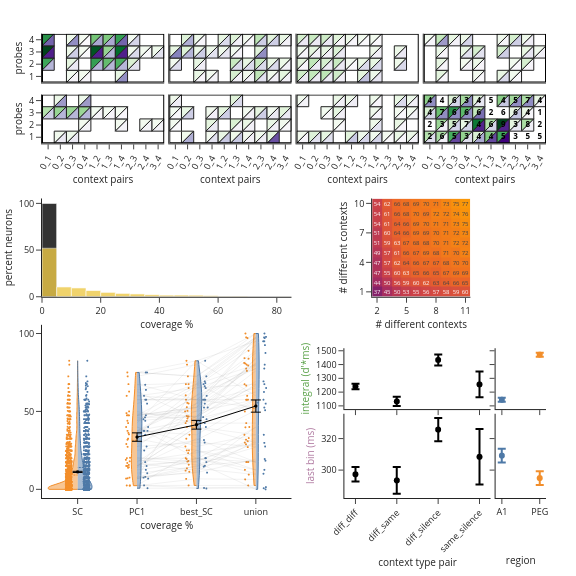

In [113]:
##### test  plot
fig, pw, ph = define_subplots()

# example tilings
for  cc, cell_eg in enumerate(cell_egs):
    panelname = f'tile_eg_{cc}'
    row, col = int(np.floor(cc/4))+1, (cc%4)+1
    # print(row, col)
    pan = panels[panelname]
    fig.add_traces(pan, rows=[row]*len(pan), cols=[col]*len(pan))

# PC1 and union tiling
pan = panels[f'tile_eg_PC']
fig.add_traces(pan, rows=[2]*len(pan), cols=[4]*len(pan))

# real vs shuffled histograms
pan = panels['SC_coverage_not_random']
fig.add_traces(pan, rows=[3]*len(pan), cols=[1]*len(pan))

# heatmap soundspace subsampling
pan = panels['space_subsampling_nomarg']
fig.add_traces(pan, rows=[3]*len(pan), cols=[3]*len(pan))

# violin plots cover sumary
pan = panels['coverage_summary']
fig.add_traces(pan, rows=[4]*len(pan), cols=[1]*len(pan))

# parameter comparison like in figure 2
pan = panels['integral_transition']
fig.add_traces(pan, rows=[4]*len(pan), cols=[3]*len(pan))

pan = panels['integral_region']
fig.add_traces(pan, rows=[4]*len(pan), cols=[4]*len(pan))


pan = panels['last_bin_transition']
fig.add_traces(pan, rows=[5]*len(pan), cols=[3]*len(pan))

pan = panels['last_bin_region']
fig.add_traces(pan, rows=[5]*len(pan), cols=[4]*len(pan))

# fig.show()
img_bytes = fig.to_image(format="png", width=pw, height=ph)
Image(img_bytes)

# saves PNG and SVG

In [111]:
folder = root_path / 'reports' / 'figures' / 'paper'
folder.mkdir(parents=True, exist_ok=True)

filename = folder / 'figure_03'
fig.write_image(filename.with_suffix('.png'))
fig.write_image(filename.with_suffix('.svg'))